In [1]:
from helper import Search, query, connections

In [2]:
PROJECT = "django"

def search():
    return Search(f"elastipy-example-commits-{PROJECT}")

### activity

#### commits per week

<AxesSubplot:xlabel='date'>

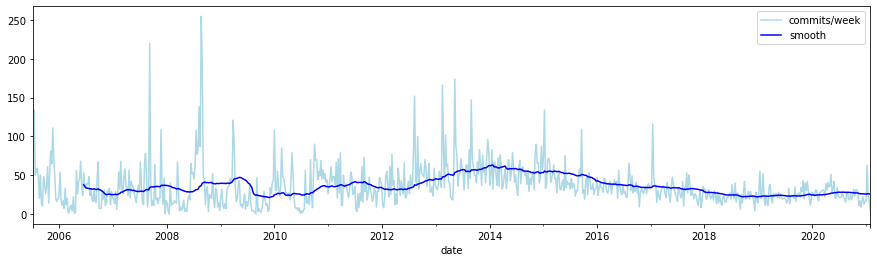

In [3]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="week")
df = agg.execute().df(to_index=True)
df["commits/week"] = df.pop("date.doc_count")
df["smooth"] = df.rolling(window=50).mean()
df.plot(figsize=(15,4), color=["lightblue", "blue"])

#### additions/deletions per week

<AxesSubplot:xlabel='date'>

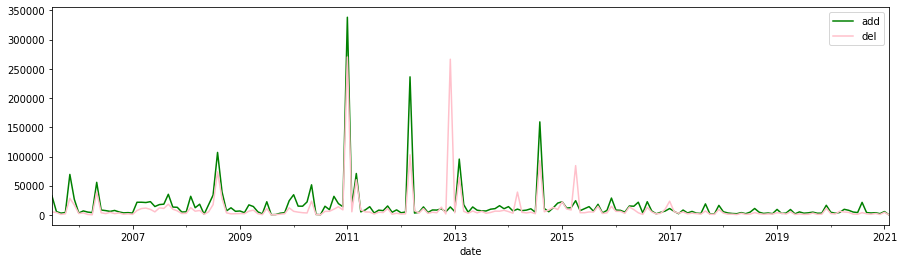

In [40]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="month")
agg.metric_sum("add", field="changes.additions")
agg.metric_sum("del", field="changes.deletions")
df = agg.execute().df(to_index=True, exclude="*doc_count")
#df[["add-sm", "del-sm"]] = df.rolling(window=50).mean()[["add", "del"]]
df.plot.line(color=["green", "pink"], figsize=(15,4))

### authors

#### top 3 authors per year

<AxesSubplot:xlabel='date'>

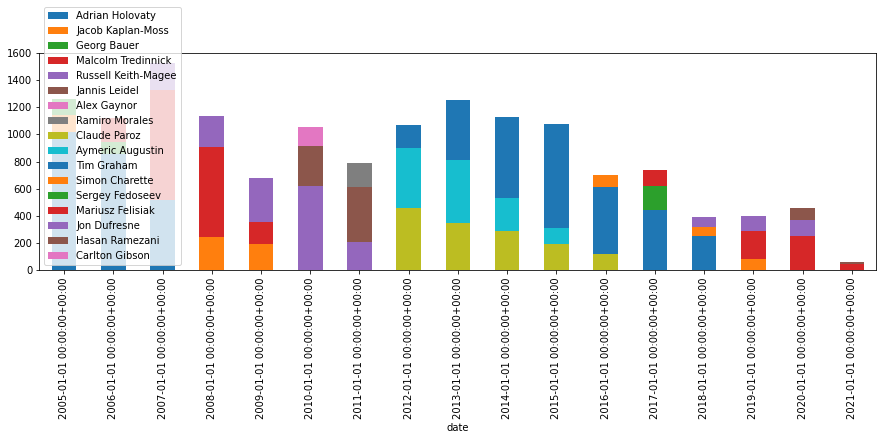

In [16]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="year")
agg = agg.agg_terms("author", field="author", size=3)
agg_top3_authors = agg
agg.execute().df(to_index=True, flat="author", exclude="*doc_count").plot.bar(figsize=(15,4), stacked=True)

#### commits of all top 3 authors  

<AxesSubplot:>

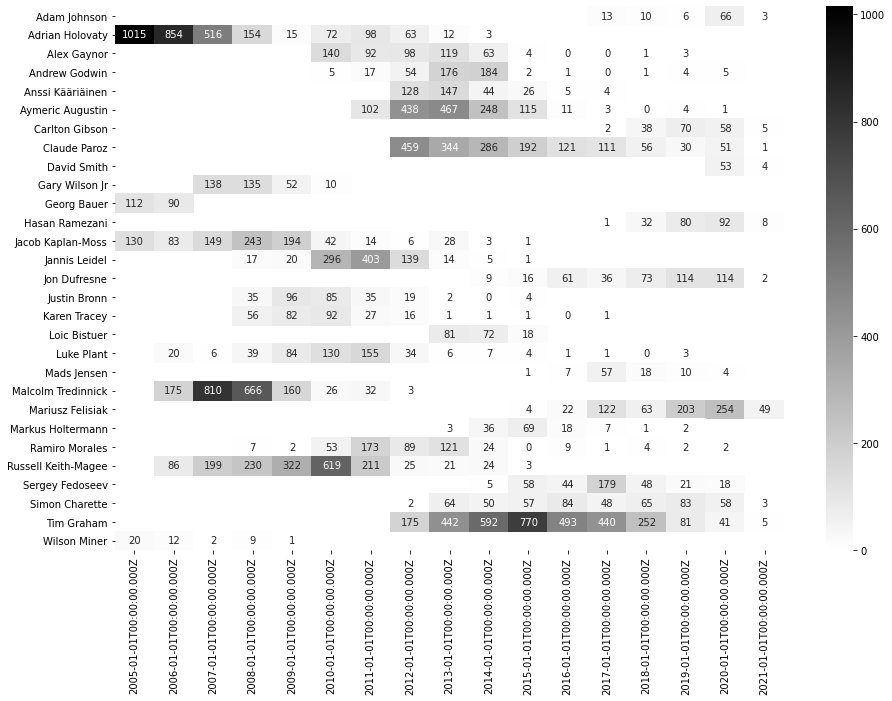

In [15]:
authors = set(k[1] for k in agg_top3_authors.keys())
s = search()
agg = s.agg_filters("author", filters={key: query.Term("author", key) for key in authors})
agg = agg.agg_date_histogram("date", calendar_interval="year")
agg.execute().plot.heatmap(sort="date", annot=True, fmt=".0f", figsize=(15, 10), cmap="gray_r")

#### top 3 average-additions per author per year

<AxesSubplot:xlabel='date'>

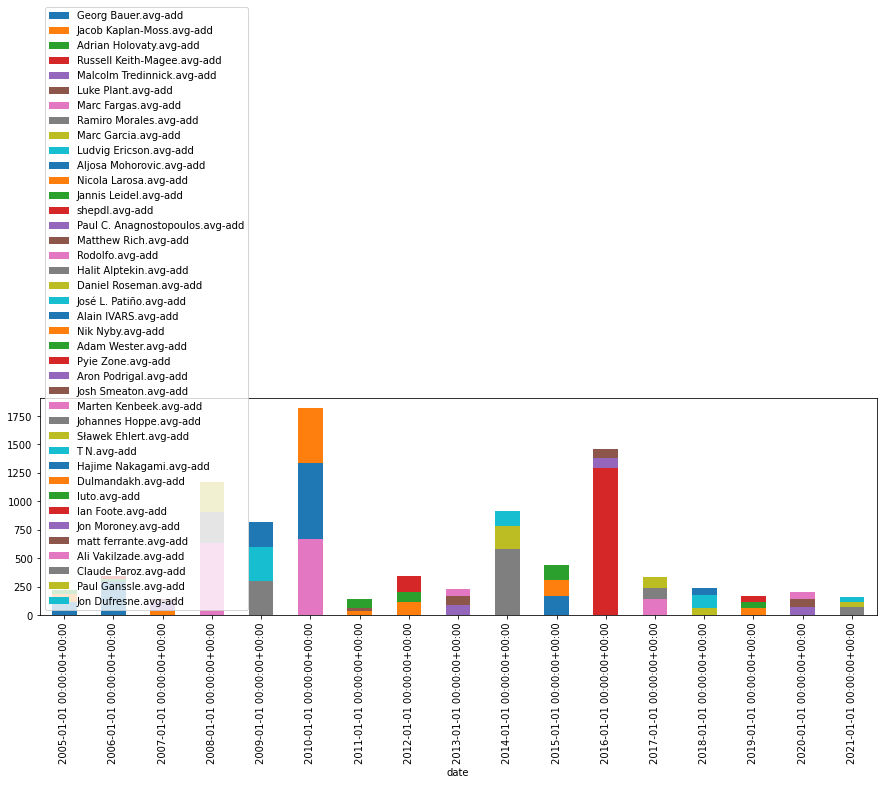

In [7]:
s = search()
agg = s.agg_date_histogram("date", calendar_interval="year")
agg = agg.agg_terms("author", field="author", size=3, order="-avg-add")
agg.metric_avg("avg-add", field="changes.additions")
agg.execute().df(to_index=True, flat="author", include=("date", "*.avg-add")) \
    .plot.bar(figsize=(15,4), stacked=True)

#### number of authors per year

2343 authors at all


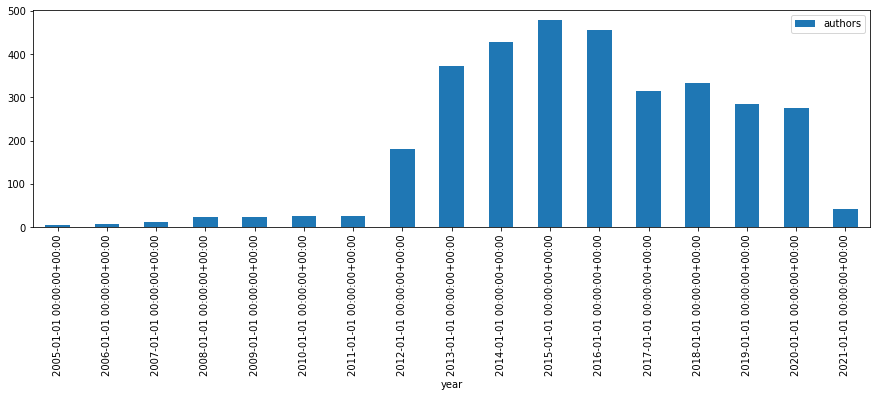

In [8]:
s = search()
global_authors = s.metric_cardinality(field="author", return_self=True)
agg = s.agg_date_histogram("year", calendar_interval="year")
agg = agg.metric_cardinality("authors", field="author")
agg.execute().plot.bar("year", "authors", figsize=(15,4))
print(next(global_authors.values()), "authors at all")

### messages

#### significant terms by year

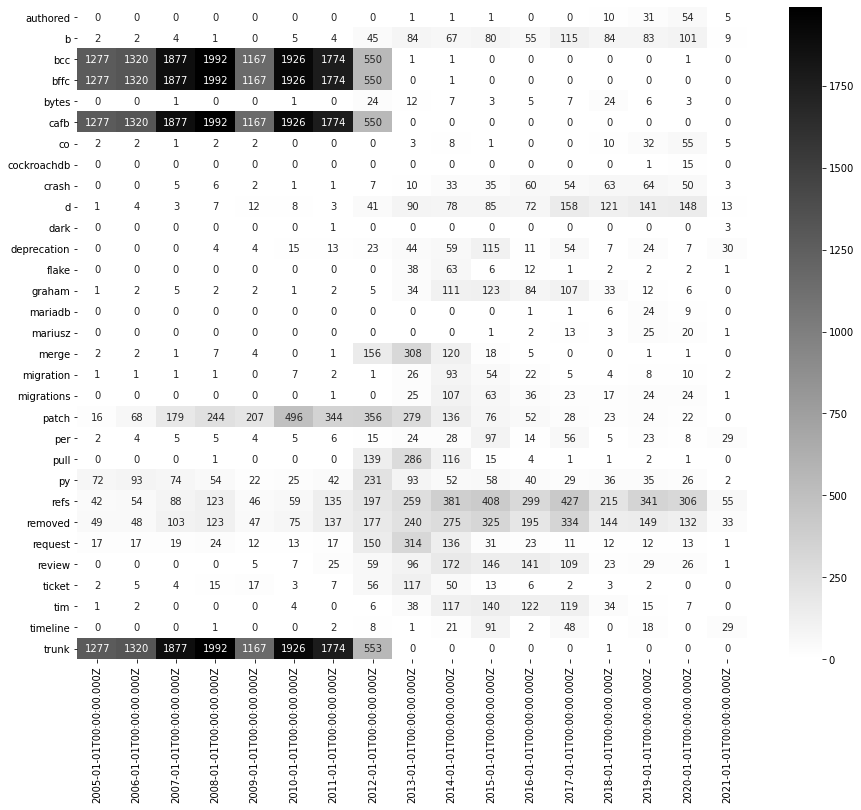

In [9]:
def significant_terms_by_year(s, field, size=4, shard_size=1000):
    agg = s.copy().agg_date_histogram("year", calendar_interval="year")
    agg = agg.agg_significant_terms(field=field, size=4, shard_size=1000)
    keywords = set(k[-1] for k in agg.execute().keys())

    agg = s.agg_date_histogram("date", calendar_interval="year")
    agg = agg.agg_filters("word", filters={key: query.Term(field, key) for key in keywords})
    agg.execute().plot.heatmap(transpose=True, annot=True, fmt=".0f", figsize=(15, 12), cmap="gray_r")
    
significant_terms_by_year(search(), "message")

### files

#### overall top 50 edited files per year

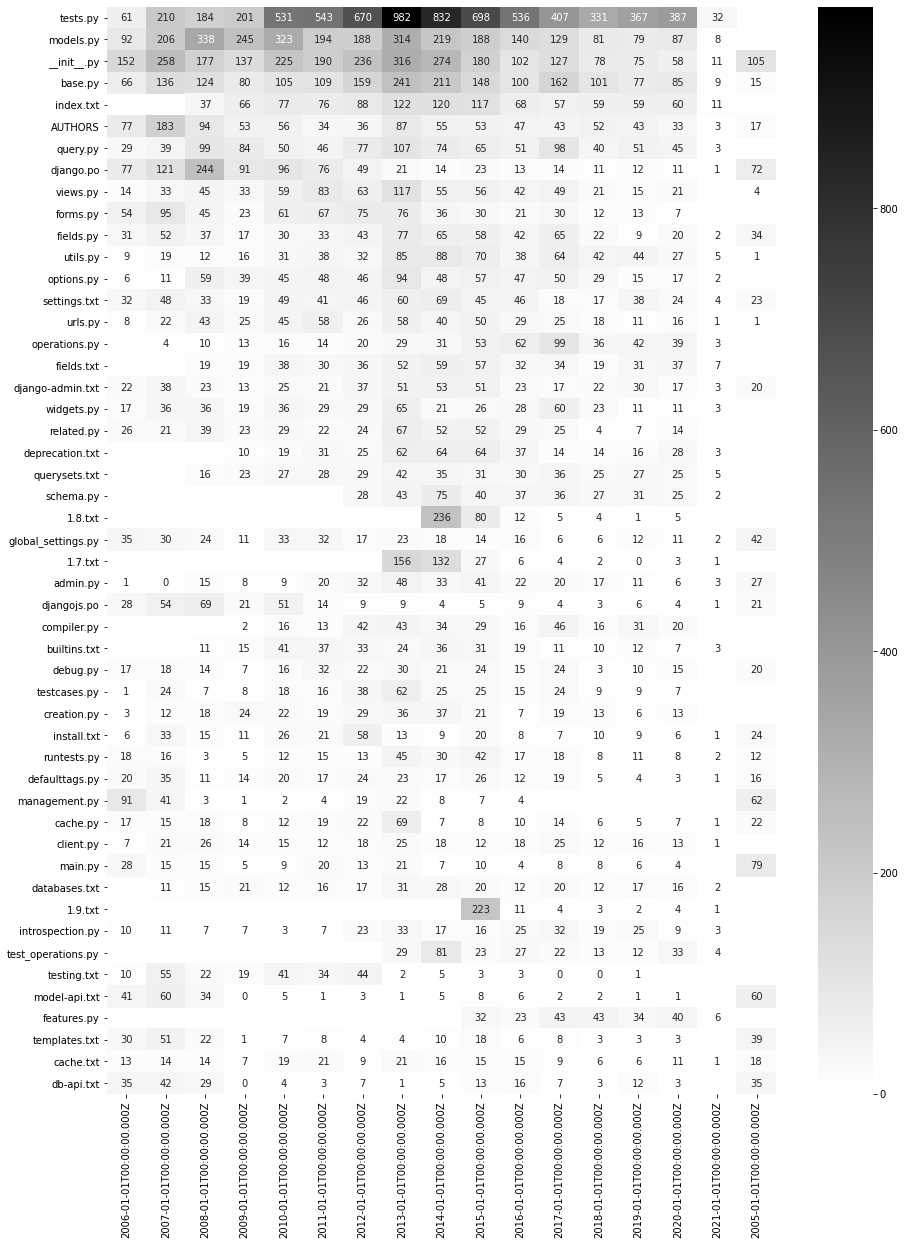

In [10]:
s = search()
agg = s.agg_terms(field="changes.file", size=50)
agg = agg.agg_date_histogram("date", calendar_interval="year")
df = agg.execute().plot.heatmap(annot=True, fmt=".0f", figsize=(15, 20), cmap="gray_r")

#### significant changed files by year

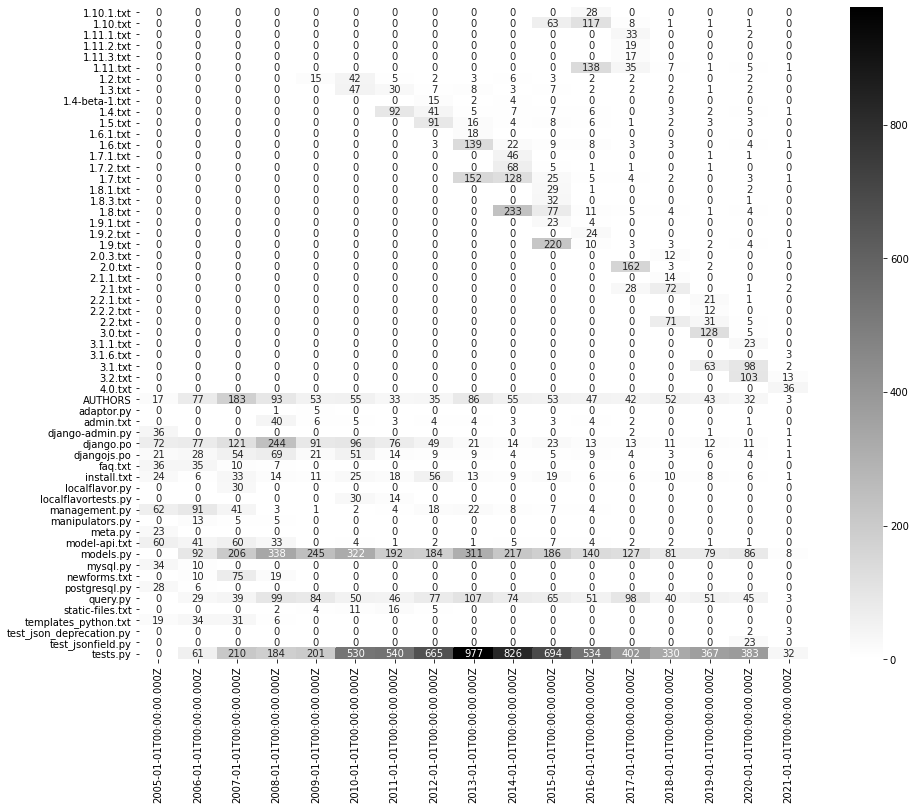

In [11]:
s = search().param(rest_total_hits_as_int=True)
# remove version specific files
s = ~s.query_string("changes.file: v*.txt OR v*.rst")
significant_terms_by_year(s, "changes.file")

<AxesSubplot:>

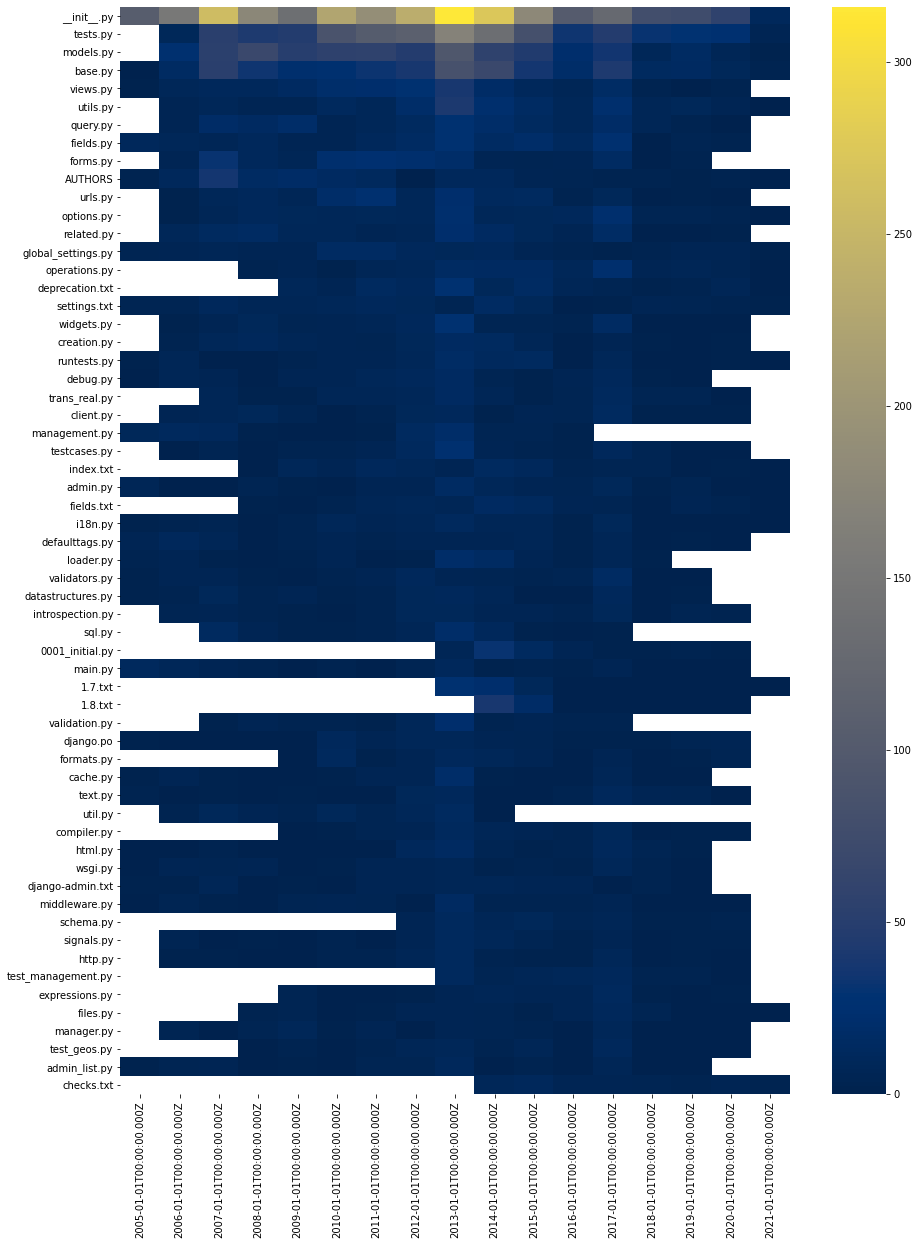

In [12]:
s = search()
s = s.query_string("changes.file: __init__.py")
agg = s.agg_terms(field="changes.file", size=60)
agg = agg.agg_date_histogram("date", calendar_interval="year")

agg.execute().plot.heatmap(figsize=(15, 20))


In [13]:
s = search()
s = s.match("message", "fix")
s.execute().dump.documents()

[
  {
    "hash": "386166970c506b5f7b70f63bfb86d1ea64a980cf",
    "author": "Andrew Godwin",
    "author_email": "andrew@aeracode.org",
    "timestamp": "2014-06-12T11:12:07-07:00",
    "message": "Fix test breakage from previous state fix\n",
    "changes": [
      {
        "filepath": "django/db/migrations/state.py",
        "file": "state.py",
        "additions": 6,
        "deletions": 0
      }
    ],
    "timestamp_hour": 11,
    "timestamp_weekday": "4 Thursday",
    "project": "django"
  },
  {
    "hash": "3800f63721f6fc1c940abfb10fe21257dcf13521",
    "author": "Aymeric Augustin",
    "author_email": "aymeric.augustin@m4x.org",
    "timestamp": "2014-05-14T10:19:48+02:00",
    "message": "Dropped fix_IE_for_vary/attach.\n\nThis is a security fix. Disclosure following shortly.\n",
    "changes": [
      {
        "filepath": "django/core/handlers/base.py",
        "file": "base.py",
        "additions": 0,
        "deletions": 2
      },
      {
        "filepath": "django/h